# Week 2

The most accessible way to measure brain activity is using electrodes placed on the scalp, referred to as electroencephalography (EEG). These are weak signals, on the order of X uV, which is ~100,000 times weaker than the voltage of a AAA battery. To measure these we use specialized electrodes and amplifiers. Since this course is focused on the signal and data analysis end of BCI, we will not 

In [2]:
import os.path as op
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy.signal as ss
import matplotlib.pyplot as plt

## Acquisition of EEG
EEG was one of the first widely accesible ways to track the activity of awake behaving subjects. It was developed in the 1920s by Hans Berger. He found that by inserting metal electrodes into the scalp, he was able to detect extremely weak electrical signals. While initially dismissed by the scientific community, he work was subsequently validated by the prominent neurophysiologist E.D. Adrien. Given the ease of obtaining the EEG signal, and that it did not require opening up the skull, it rapidly became a widespread tool for the study of brain activity. Today, it is commonly used in medicine to help diagnose medical conditions, such as epilepsy, characterize sleep distrubances using polysomnography, and in research labs to further our understanding of brain function. It is also a technique for studying brain activity that is readily accessible to the amature, with many companies selling do-it-yourself EEG recording kits (e.g. X). For a thorough manual on acquiring and interpreting EEG signals check out https://academic.oup.com/book/35515.

### EEG signal
As we reviewed in Week 1, the transmembrane currents of neurons produce voltages that can be picked up by electrodes. As those electrodes are moved farther away from the neurons, this voltage falls off. When ones electrode reaches the surface of the scalp, the voltages from individual neurons are so weak that they cannot be distinguished from each other. Instead, it is the shared transmembrane currents across all the neurons within several centimeters of the electrode that make up the EEG signal. We saw that the very large currents contributed to the action potentials of single neurons were not visible once we were 2 cm from the neurons, but the shared slow fluctuations and synaptic currents were evident. It is estimated that the total area of cortex required to be coactivated sufficiently to generate a detectable scalp potential is around 6 cm<sup>2</sup> (Ebersole 1997). Consequently, the EEG reflects widespread activations.

Our simplified model ignored a few details that apply to real brains and that influence the EEG. First, neurons are not 'point-sources', i.e. they are not a single current source but have dendrites that currents also flow through. This create a dipole that influenes the distribution of transmembrane currents and the voltages recorded at the scalp. Second, the cortical surface has a convoluted surface, with neurons oriented at different angles with respect to the scalp. This angling affects both the magnitude and the sign of voltage picked up on the scalp, making it exceptionally difficult to reconstruct exactly what neural sources generated any recorded potential. Lastly, we assumed that the conductivity of the tissue between the neuron and the scalp electrode was Ohmic (homogenous), but this is not the case. A neural potential passes through brain tissue, the cerebrospinal fluid, dura mater that encapsulates the brain, bone of the skull, and the skin. These tissues have different conductivities, further complicating the reconstruction of the underlying neural generators.

### Electrode placement
The electrodes used in EEG research are small metal discs that are pressed into a conductive gel resting on the scalp. This gel allows electrical activity on the scalp to easily conduct to the electrode. Often the skin under the gel has to be abrated a bit to remove the top layer of dead skin cells and oil that have low conductivity.

[DIAGRAM OF EEG ELECTRODE]

While it is not possible to exactly reconstruct the EEG sources, by placing multiple electrodes across the scalp one can observe some coarse localization of brain activity (see https://robertoostenveld.nl/electrode/#jasper1958 for a nice discussion). For instance, presenting an auditory stimulus elicits a potential over the portion of the scalp overlying the temporal lobe, where auditory cortex is, while visual stimuli elicit potentials over occipital cortex, where visual cortex is [CITATIONS]. So, there seems to be some loose relationship between a signal in the EEG and the source of that signal. This highlights the need to place multiple electrodes over the scalp to get a complete picture of the brain activity. 

In 1958 a standard was adopted for placement and naming of EEG electrodes with respect to features on the skull. It has been updated periodically over the decades (https://journals.lww.com/clinicalneurophys/Citation/1994/01000/Guideline_Thirteen__Guidelines_for_Standard.14.aspx), with the most recent incarnation known as the 10-20 system. The 10 refers to the percent distance between adjacent electrodes along the front-back axis of the skull (also referred to as rostro-caudal or anterior-posterior). 20 refers to the percent distance between adjacent electrodes along the left-right axis of the skull (also referred to as medial-lateral). Electrodes are named with a combination of letters and numbers. Each starts with letters corresponding to the region of the brain they lie immediately over:
|Letters|Region|
|-----|----|
|Fp| Prefrontal|
|F| Frontal|
|C| Central|
|T| Temporal|
|P| Parietal|
|O| Occipital|

Each is followed by a number or the letter 'z'. 'z' is used for sites along the midline, even numbers on the right hemisphere, and odd numbers on the left hemisphere. The numbers start at 1 and increase as electrode sites are moved away from the midline, i.e. laterally. This layout looks like:
[IMAGE OF 10-20 SYSTEM]

Recently, the number of recording sites has increased because of advances the miniaturization of recording systems. The recordings we will draw from for these lectures use the 10-20 extended system, that features more recording sites. In addition to the names used above, also included are sites that are equally close to two areas and will have their letters joined, e.g. FC (frontal-central) and PO (parietal-occipital). Its layout is:
[IMAGE OF EXTENDED 10-20 SYSTEM]

In addition to electrodes that are explicitly targeted to record brain activity, additional electrodes are used for referencing and detection of contaminating noise and artifacts.

### Referencing
Since voltage is a measure of the work needed to move a charge from one place to another, it is always measured between two points. The point whose signal we seek to measure is referred to as the *active* site. It is measured with respect to another point, the *ground*. Ideally, the ground would be at a point in space that is infinitely far away from the electrode and with no charges near it to contaminate the potential we are attempting to measure at the EEG site. This is not practical (nor would it work due to limitations in electronic hardware). Instead, researchers often place the ground immediately behind the ear (referred to as the mastoid). If we only measured our signal at the active site then we face a new problem: there are numerous sources of environmental electrical noise that envelope the entire head, such as emissions from the AC power in the walls. To eliminate that, one also records from a *reference* electrode, whose signal is subtracted from the active. Any signal that is shared between the active and reference sites is removed (which includes signal at the ground site, since both the active and reference are measured relative to the same ground electrode). The degree of removal is referred to as the *common-mode rejection ratio* and depends on the quality of the amplifiers and conductivity between the electrodes and scalp. A good common-mode rejection ratio is 70 decibels (dB), which means that the shared signal is reduced by a factor of 10,000,000 ($dB = 10log_{10}(x)$)!

[INSERT FIGURE OF ACTIVE VS GROUND VS REFERENCE SITES]

### Artifacts and noise
Environmental electrical noise that is homogenous across the head will be elimited by the proper referencing described above. However, there are other sources of electrical interference that are not homogenous across this head. This is especially true for those arising from the head itself. Recall from our discussion of extracellular potentials that voltage falls off with distance. This means that electrodes close to a location on the head producing non-neural electrical signals will record very different signals. In contrast, the differnce between noise sources far from the head will be much smaller. 

These sources are sometimes referred to as noise, and other times as artifacts. In general, an artifact is a transient event, while noise is continuiouly occuring. Let's consider the most common types.

#### AC power line noise
Even with excellent referencing, AC power interference can still leak into recordings and must be dealt with. The easiest way to eliminate it is to filter out any signals in the EEG that are at or above the frequency of the AC signal, which in the US is at 60 Hz.

#### Eye blinks and movement artifacts
Your eyeball is polarized, with large potential difference between the cornea and retina. This potential, referred to as the *electrooculogram* (https://pubmed.ncbi.nlm.nih.gov/31277871/) affects electrodes on the scalp, with those at frontal sites just above the eyes, such as F or Fp, picking it up most strongly. So long as the eye remains motionless, this just causes a constant offset in the voltage at an EEG electrode. But eyes move, a lot, especially when subjects are engaged in the kinds of activities we want to relate back to the brain. Your eyes constantly dart around, called saccading, between different spots in your field of view. When the eye moves or blinks, the voltages at your EEG sites change. Since each EEG electrode will pick this up differently, one cannot simply just rely on referencing to eliminate. The simplest way to deal with these is to measure the eye movements directly by placing electrodes adjacent to the subject's eyes, and then exclude periods when eye movements were present from subsequently analysis. More sophisticated approaches (e.g. independent component analysis) can isolate and remove the contribution of eye blinks to the EEG, allowing one to analyze periods where they occurred. These are beyond the purview of this course.

#### Muscle artifacts
Your muscles are electromechanical devices that put out their own potentials, called *electromyographic* activity, abbreviated EMG. When a muscle is depolarized, it can produce a strong Na<sup>+</sup> and Ca<sup>2+</sup> action potential. Muscle contraction is driven by a barrage of these fast potentials, which can be picked up on electrodes many centimeters away. EMG will be most associated with mouth, forehead, and neck movements. Since EMG is associated with action potentials, its activity will be very fast relative to the slower activities detected in EEG. This makes it easy to detect and filter out, which will be covered below.

#### Skin potentials
The skin is a conductive medium with its own voltage potential between its inside and outside. This voltage changes with the skin's conductivity. Often this occurs slowly over time by the opening and closing of sweat glands and the hydration of the skin by the conductive gel. It can also change suddenly when the electrode contact is moved. Often this potential can be corrected for calculating the mean potential on an electrode shortly before the moment we want to analyze, and subtracting it out.

### A simple model of the EEG signal
We have just covered a variety of neural and non-neural sources for our EEG signal. This can be thought of as an equation:

$$ EEG = Neural_{spon} + Neural_{evoked} + EOG + EMG + Scalp + ACPower $$

For the rest of the lesson, we will go over how to eliminate or account for each these. In particular, we are interested in extracting $Neural_{evoked}$ component.

## Evoked response potentials
Whenever a stimulus is presented to a subject, it produces a chain of activation throughout the nervous system. Starting at the peripheral sensory receptors that detect the stimulus (such as the retina), a cascade of neural activation moves towards the cortex. Upon reaching the cortex, it is conveyed for further processing to determine what the form of the stimulus was and its relevance. 

## Working with EEG data

### Loading EEG signals
DISCUSS .SET FILE
PLOT STACKED EEG LINES

### Time series data
SAMPLING A CONTINUOUS SIGNAL, SAMPLE RATE, RESOLUTION, MEAN, VARIANCE, AUTOCORRELATION

### Meta data
DISCUSS .SET, .TSV, .JSON
ROUTINES TO LOAD DATA

### Noise removal
BASELINE SUBTRACT, MOVING AVERAGE, CONVOLUTION, FILTERS, 

## Event-related potentials
### Evoking them
EXPERIMENTAL DESIGN, WINDOWING EEG SIGNALS BY EVENTS
### Time course
COMPONENTS, DEFINED BY LATENCY, MAGNITUDE, SIGN, DURATION
VARIABILITY ACROSS REPITITIONS WITH BOOTSTRAPPING
### Topography
EEG HAS GOOD TEMPORAL RESOLUTION, BUT POOR SPATIAL RESOLUTION. LOCALIZE ELECTRODES WHERE ERP COMPONENT IS STRONGEST

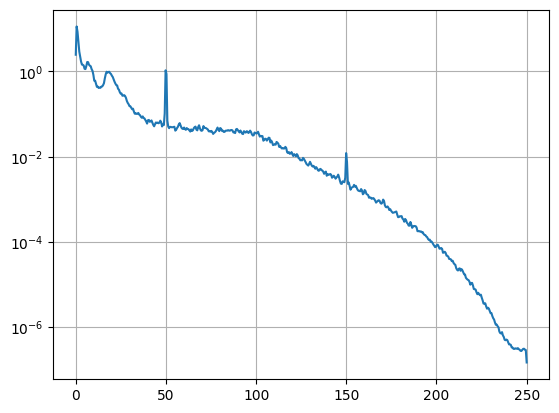

In [3]:
root_dir = '/Users/drewheadley/Documents/Courses/DataScienceProgram/DecodingTheBrain/Datasets/ds003690'
subj = 'AB58'
eeg_file = op.join(root_dir, 'sub-{}/eeg/sub-{}_task-passive_run-1_eeg.set'.format(subj, subj))
evt_file = op.join(root_dir, 'sub-{}/eeg/sub-{}_task-passive_run-1_events.tsv'.format(subj, subj))
#'/Users/drewheadley/Documents/Courses/DataScienceProgram/DecodingTheBrain/Datasets/ds003690/sub-AB4/eeg/sub-AB4_task-passive_run-1_eeg.set'
#evt_file = '/Users/drewheadley/Documents/Courses/DataScienceProgram/DecodingTheBrain/Datasets/ds003690/sub-AB4/eeg/sub-AB4_task-passive_run-1_events.tsv'
eeg = sio.loadmat(eeg_file)
evt = pd.read_csv(evt_file, sep='\t')

samp_rate = eeg['srate'][0][0]
eeg_data = eeg['data']
nchan = eeg_data.shape[0]
nsamp = eeg_data.shape[1]
chan_info = eeg['chaninfo'][0][0][1]
ref_elec = eeg['ref']

evt_times = evt['sample'][evt['trial_type']=='cue'].values
# create a matrix of indices for the 200 ms window around each event
evt_inds = np.tile(evt_times, (int(samp_rate), 1)).T + np.arange(-int(samp_rate/2), int(samp_rate/2))

ind = 40
sel_eeg = eeg_data[ind,:]
f, Pxx_den = ss.welch(sel_eeg, samp_rate, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.grid()

In [4]:
chan_info

array(['Fp1 69 -2.854012 12.903291 -1.520481 ',
       'Fpz 69 0.583218 13.494058 -1.592608  ',
       'Fp2 69 3.935400 12.477923 -2.102277  ',
       'AF3 69 -3.023524 12.428141 1.361401  ',
       'AF4 69 4.304501 11.727693 0.427403   ',
       'F7 69 -6.639328 8.170529 -1.526560   ',
       'F5 69 -5.876012 9.542894 0.800148    ',
       'F3 69 -4.229360 10.265764 2.418731   ',
       'F1 69 -1.882614 11.018632 4.587177   ',
       'Fz 69 0.596303 10.217070 4.293318    ',
       'F2 69 3.996278 10.694478 3.944555    ',
       'F4 69 5.631967 9.848669 2.084015     ',
       'F6 69 6.969560 8.879675 -0.060155    ',
       'F8 69 7.878357 7.523402 -2.148623    ',
       'FT7 69 -7.918441 5.400486 -0.685157  ',
       'FC5 69 -6.848348 6.444450 1.872787   ',
       'FC3 69 -5.007377 6.820720 4.378383   ',
       'FC1 69 -2.332303 7.275606 6.020996   ',
       'FCz 69 0.892164 7.275017 6.676030    ',
       'FC2 69 3.868832 7.218509 5.929260    ',
       'FC4 69 6.393416 6.765655 4.16185

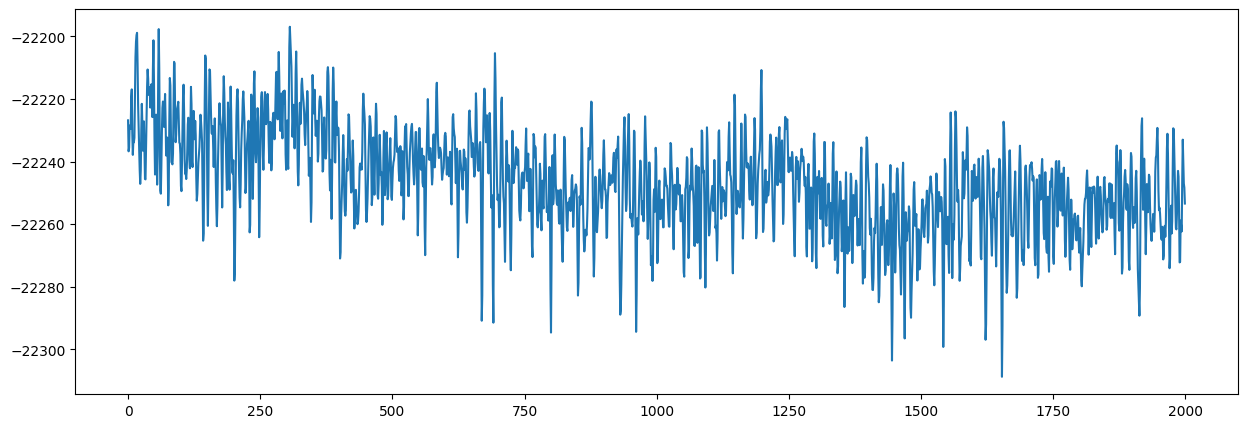

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(eeg_data[1,10000:12000])

Text(0.5, 1.0, 'CP6 69 7.889221 -0.063045 4.064806   ')

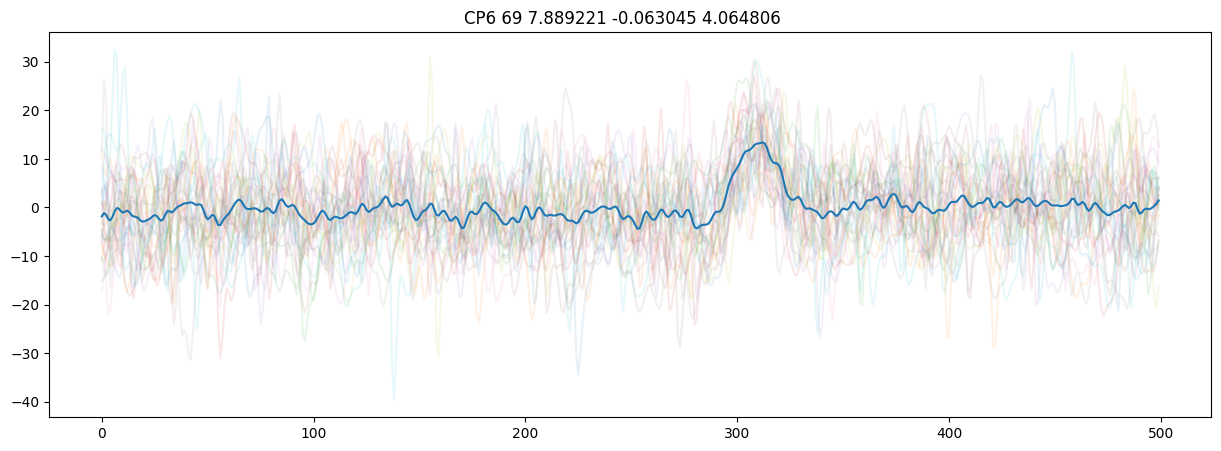

In [451]:
ind = 40
sel_eeg = eeg_data[ind,:]
# apply 60 hz notch filter
b,a = ss.butter(2, 100, btype='low', fs=samp_rate)

#freq, h = ss.freqz(b,a,fs=samp_rate)
#plt.plot(freq, np.abs(h))
'''seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='k')
sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='r')'''

sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg.T-np.mean(seg_eeg,axis=1), alpha=0.1)
plt.plot(np.mean(seg_eeg.T-np.mean(seg_eeg,axis=1),axis=1))
plt.title(chan_info[ind])

In [ ]:
'''seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='k')
sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='r')'''

sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg.T-np.mean(seg_eeg,axis=1), alpha=0.1)
plt.plot(np.mean(seg_eeg.T-np.mean(seg_eeg,axis=1),axis=1))
plt.title(chan_info[ind])

In [ ]:
# power specturm of sel_eeg
